## Main Code for the DistilBERT model for earnings reports and news articles
by: Alexander Schlaubitz

This code defines complexity formulas and traines a DistilBERT model for the prediction of text sentiment for Swiss earnings reports and news articles of 15 small- and mid caps. This notebook must be executed using Google Colab and respective input files should be stored on there as well to ensure functionality.

In [1]:
# install simpletransformers
!pip install simpletransformers #-U

### Complexity Part
This section defines the calculations for the Wiener Sachtextformel and the Flesch Score. Furthermore all earnings reports and news articles are tokenized on a sentence level and then both scores are applied to each sentence.


In [2]:
#mount drive for data imports
#4/1AY0e-g7Pt19BU8hxrigSX1tq3XLfUSBhEJRO86QnH3cuvhw0GKMqrZVAieU
from google.colab import drive
drive.mount('/content/drive')

#load finBERT with german translations
import pandas as pd
df = pd.read_excel('/content/drive/My Drive/colab_notebooks/correct_ratings.xlsx')

Mounted at /content/drive


In [3]:
df

,original row,Text,rating,german via deepl
0,0,"According to Gran , the company has no plans t...",1,"Laut Gran hat das Unternehmen keine Pläne, die..."
1,1,With the new production plant the company woul...,2,Mit der neuen Produktionsanlage würde das Unte...
2,2,"For the last quarter of 2010 , Componenta 's n...",2,Im letzten Quartal 2010 verdoppelte sich der U...
3,3,"In the third quarter of 2010 , net sales incre...",2,Im dritten Quartal 2010 stiegen die Umsatzerlö...
4,4,Operating profit rose to EUR 13.1 mn from EUR ...,2,"Das Betriebsergebnis stieg von EUR 8,7 Mio. im..."
...,...,...,...,...
3448,3448,Operating result for the 12-month period decre...,0,Das Betriebsergebnis für den 12-Monats-Zeitrau...
3449,3449,HELSINKI Thomson Financial - Shares in Cargote...,0,HELSINKI Thomson Financial - Die Aktien von Ca...
3450,3450,LONDON MarketWatch -- Share prices ended lower...,0,LONDON MarketWatch -- Die Aktienkurse endeten ...
3451,3451,Operating profit fell to EUR 35.4 mn from EUR ...,0,"Das Betriebsergebnis fiel von EUR 68,8 Mio. im..."


In [4]:
df.rating.value_counts()

1    2146
2     887
0     420
Name: rating, dtype: int64

In [5]:
# The below code was taken from: https://github.com/pablotheissen/wstf and only slightly adapted.

!pip install Pyphen


import pyphen
import re
from collections import Counter, defaultdict

#Demotext to test functionality
demotext = "Die Unternehmen zeigten allesamt Verluste von bis 2 Millionen Euro, was sich durch die globale Pandemie erklärten lässt."

#function counts the nr. of sentences
def count_sentences_german(text):
    #Count number of sentences by counting end-dots but avoid counting
    #abbrevations like »u.a.« 
    text = re.sub("[^a-zA-ZäöüÄÖÜß\.!? ]", " ", text)
    return len(re.findall(
        "[a-zäöüß)]{3}[\.?!][\n\s]", text)) + 1

#function counts the nr. of syllables
def count_syllables_german(text):
    """ Count number of syllables:
        1. Clean up text
        2. Split text into seperate words seperated by a space
        3. Hyphenate every single word with pyphen
        4. Count number of words + number of hyphens
    """
    dic = pyphen.Pyphen(lang='de_DE')

    # Option to  filter out certain characters from the text
    # text = re.sub("[-–\.,:;'()„“»«›‹/•0-9]", " ", text)
    text = re.sub("[^a-zA-ZäöüÄÖÜß ]", " ", text) # special chars/numbers
    # text = re.sub("\s[A-ZÄÖÜ]+\s", " ", text) # One-character words
    # text = re.sub("\s[a-zäöüß]\s", " ", text) # One-character words
    text = re.sub("\s+", " ", text)
  
    # print(text)

    number_of_syllables = 0
    syllables_per_word = defaultdict(int)
    characters_per_word = defaultdict(int)
    for word in text.split(" "):
        # print(word)
        syllable_counter = 0
        # hyphenate word
        syllables = dic.inserted(word)
        # count first syllable of word
        syllable_counter += 1
        # and count the other syllables
        syllable_counter += syllables.count("-")
        number_of_syllables += syllable_counter
        syllables_per_word[syllable_counter] += 1
        characters_per_word[len(word)] += 1
        # print("  Chars: " + str(len(word))) #optional additional print out for more details
        # print("  Syllables: " + str(syllable_counter)) #also optional for more details print out

    return number_of_syllables, syllables_per_word, characters_per_word


def wiener_sachtext_formel(ms, sl, iw, es):
    """https://de.wikipedia.org/wiki/Lesbarkeitsindex#Wiener_Sachtextformel
    Keyword arguments:
    MS -- Prozentanteil der Wörter mit drei oder mehr Silben,
    SL -- mittlere Satzlänge (Anzahl Wörter),
    IW -- Prozentanteil der Wörter mit mehr als sechs Buchstaben,
    ES -- Prozentanteil der einsilbigen Wörter.
    """
    #print("\nWIENER SACHTEXT FORMEL")
    #print("   MS: {:.3}".format(ms))
    #print("   SL: {:.3}".format(sl))
    #print("   IW: {:.3}".format(iw))
    #print("   ES: {:.3}".format(es))
    wsf = 0.1935 * ms + 0.1672 * sl + 0.1297 * iw - 0.0327 * es - 0.875
    return wsf



     |████████████████████████████████| 2.0MB 8.2MB/s 


In [6]:
def apply_wiener(text):
    demotext = re.sub("\s+", " ", text)
    number_of_words = demotext.count(" ") + 1
    demotext = re.sub("\.+", ".", demotext)
    number_of_sentences = count_sentences_german(demotext)
    number_of_syllables, syllables_per_word, characters_per_word = count_syllables_german(
    demotext)
    avg_sentence_length = number_of_words / number_of_sentences
    avg_number_of_syllables_per_word = number_of_syllables / number_of_words

    # Initialize Wiener Sachtext Formel
    # print(syllables_per_word.items())
    # count number of words with number of syllables >= 3
    # key of syllables_per_word is number of syllables, value is number of
    #   words with this syllable-number
    number_of_words_with_three_or_more_syllables = sum(
        [v for k, v in syllables_per_word.items() if k >= 3])
    #print(characters_per_word.items())
    number_of_words_with_six_or_more_characters = sum(
        [v for k, v in characters_per_word.items() if k >= 6])
    wsf = wiener_sachtext_formel(
        number_of_words_with_three_or_more_syllables / number_of_words * 100,
        avg_sentence_length,
        number_of_words_with_six_or_more_characters / number_of_words * 100,
        syllables_per_word[1] / number_of_words * 100)
    #print("{:.3}".format(wsf))
    return wsf
#apply Wiener score calculation to german finphrase sentences
df['wiener_score'] = [apply_wiener(x) for x in df['german via deepl']]
df

#Die Skala beginnt bei Schulstufe 4 und endet bei 15, wobei ab der Stufe 12 eher von Schwierigkeitsstufen als von
#Schulstufen gesprochen werden sollte. Ein Wert von 4 steht demnach für sehr leichten Text, dagegen bezeichnet 15
#einen sehr schwierigen Text.

,original row,Text,rating,german via deepl,wiener_score
0,0,"According to Gran , the company has no plans t...",1,"Laut Gran hat das Unternehmen keine Pläne, die...",10.961800
1,1,With the new production plant the company woul...,2,Mit der neuen Produktionsanlage würde das Unte...,15.660458
2,2,"For the last quarter of 2010 , Componenta 's n...",2,Im letzten Quartal 2010 verdoppelte sich der U...,9.349756
3,3,"In the third quarter of 2010 , net sales incre...",2,Im dritten Quartal 2010 stiegen die Umsatzerlö...,5.681133
4,4,Operating profit rose to EUR 13.1 mn from EUR ...,2,"Das Betriebsergebnis stieg von EUR 8,7 Mio. im...",6.003500
...,...,...,...,...,...
3448,3448,Operating result for the 12-month period decre...,0,Das Betriebsergebnis für den 12-Monats-Zeitrau...,7.296600
3449,3449,HELSINKI Thomson Financial - Shares in Cargote...,0,HELSINKI Thomson Financial - Die Aktien von Ca...,17.159212
3450,3450,LONDON MarketWatch -- Share prices ended lower...,0,LONDON MarketWatch -- Die Aktienkurse endeten ...,15.064200
3451,3451,Operating profit fell to EUR 35.4 mn from EUR ...,0,"Das Betriebsergebnis fiel von EUR 68,8 Mio. im...",5.609400


In [7]:
if __name__ == "__main__":
    demotext = re.sub("\s+", " ", demotext)
    number_of_words = demotext.count(" ") + 1
    demotext = re.sub("\.+", ".", demotext)
    number_of_sentences = count_sentences_german(demotext)
    number_of_syllables, syllables_per_word, characters_per_word = count_syllables_german(
    demotext)
    avg_sentence_length = number_of_words / number_of_sentences
    avg_number_of_syllables_per_word = number_of_syllables / number_of_words

    # Initialize Wiener Sachtext Formel
    # print(syllables_per_word.items())                                                         
    # count number of words with number of syllables >= 3
    # key of syllables_per_word is number of syllables, value is number of
    #   words with this syllable-number
    number_of_words_with_three_or_more_syllables = sum(
        [v for k, v in syllables_per_word.items() if k >= 3])
    print(characters_per_word.items())
    number_of_words_with_six_or_more_characters = sum(
        [v for k, v in characters_per_word.items() if k >= 6])
    wsf = wiener_sachtext_formel(
        number_of_words_with_three_or_more_syllables / number_of_words * 100,
        avg_sentence_length,
        number_of_words_with_six_or_more_characters / number_of_words * 100,
        syllables_per_word[1] / number_of_words * 100)
    print("{:.3}".format(wsf))

dict_items([(3, 5), (11, 1), (7, 2), (8, 3), (9, 2), (4, 2), (5, 2), (0, 1)])
13.8


In [8]:
#Define Flesch Score
!pip install textstat

import textstat
#textstat documentation under: https://pypi.org/project/textstat/
text = "nomine patri e spirite santi"

#Score Difficulty for Flesch reading ease score
# 90-100 	Very Easy
# 80-89 	Easy
# 70-79 	Fairly Easy
# 60-69 	Standard
# 50-59 	Fairly Difficult
# 30-49 	Difficult
# 0-29 	Very Confusing

textstat.set_lang('de') #setting language to german

def apply_flesch(text): #write function so that i can apply it to a pandas dataframe
    flesch_score = textstat.flesch_reading_ease(text)
    return flesch_score

     |████████████████████████████████| 102kB 5.9MB/s 


In [9]:
#apply flesch score
df['flesch_score'] = [apply_flesch(x) for x in df['german via deepl']]
df

,original row,Text,rating,german via deepl,wiener_score,flesch_score
0,0,"According to Gran , the company has no plans t...",1,"Laut Gran hat das Unternehmen keine Pläne, die...",10.961800,49.85
1,1,With the new production plant the company woul...,2,Mit der neuen Produktionsanlage würde das Unte...,15.660458,8.60
2,2,"For the last quarter of 2010 , Componenta 's n...",2,Im letzten Quartal 2010 verdoppelte sich der U...,9.349756,77.40
3,3,"In the third quarter of 2010 , net sales incre...",2,Im dritten Quartal 2010 stiegen die Umsatzerlö...,5.681133,75.40
4,4,Operating profit rose to EUR 13.1 mn from EUR ...,2,"Das Betriebsergebnis stieg von EUR 8,7 Mio. im...",6.003500,76.90
...,...,...,...,...,...,...
3448,3448,Operating result for the 12-month period decre...,0,Das Betriebsergebnis für den 12-Monats-Zeitrau...,7.296600,66.40
3449,3449,HELSINKI Thomson Financial - Shares in Cargote...,0,HELSINKI Thomson Financial - Die Aktien von Ca...,17.159212,6.60
3450,3450,LONDON MarketWatch -- Share prices ended lower...,0,LONDON MarketWatch -- Die Aktienkurse endeten ...,15.064200,27.30
3451,3451,Operating profit fell to EUR 35.4 mn from EUR ...,0,"Das Betriebsergebnis fiel von EUR 68,8 Mio. im...",5.609400,67.25


In [10]:
import numpy as np
np.corrcoef(df.wiener_score,df.flesch_score )
#correlation of -0.81, correlation is negative because the higher the wiener score the harder the text, but the lower
#the flesch reading ease score the harder the text, so negative correlation is a good sign.

array([[ 1.        , -0.81571073],
       [-0.81571073,  1.        ]])

In [11]:
#!pip install nltk
import nltk
nltk.download('punkt')
sentences = nltk.sent_tokenize(text,language='german')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
#import all news articles and earnings reports
excel_test = pd.read_excel('/content/drive/My Drive/colab_notebooks/all_texts.xlsx')
excel_test


,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text
0,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,"Ausblick Straumann: Jahresgewinn von 74,2 Mill..."
1,STMN,19349,Straumann-30_04_2020-Medienmitteilung.txt,quarterly_earnings_report,company,2020-04-30,Die Straumann Group reagiert schnell auf COVID...
2,STMN,19349,Straumann-Q1-25_04_2018-Medienmitteilung.txt,quarterly_earnings_report,company,2018-04-25,Straumann: Starkes Wachstum setzt sich fort – ...
3,STMN,19349,Straumann-30_04_2019-Q1-Medienmitteilung,quarterly_earnings_report,company,2019-04-30,Vielversprechender Jahresauftakt mit 17% organ...
4,STMN,19349,STMN_16.02.2021_3.txt,news,cash.ch,2021-02-16,Straumann hat im zweiten Semester wieder auf d...
5,STMN,19349,STMN_16.02.2021_2.txt,news,cash.ch,2021-02-16,Straumann verdient wegen Corona-Pandemie wenig...
6,STMN,19349,Strauman-yearly_2020_16.02.2021_annual_earning...,annual_earnings_report,company,2021-02-16,Die Straumann Group beendet ein herausfordernd...
7,STMN,19349,Straumann_yearly_2018-19.02.2019_Medienmitteilung,annual_earnings_report,company,2019-02-19,"Straumann: starkes viertes Quartal 2018, Jahre..."
8,STMN,19349,STMN_yearly_2017_15.02.2018_Medienmitteilung,annual_earnings_report,company,2018-02-15,Straumann Group: Umsatz überschreitet Milliard...


In [13]:
#define sentence tokenizer
def apply_tokenize(x):
    sentence = nltk.sent_tokenize(x,language='german')
    return sentence

In [14]:
#reform dataframe so that text gets tokenized and the ticker, document name and publication date are attached to it
c = pd.DataFrame([apply_tokenize(x) for x in excel_test['original_text']], index=[excel_test.company_ticker, excel_test.market_cap_mio_chf, excel_test.document_name, excel_test.document_type, excel_test.source, excel_test.publication_date]).stack()
c = c.reset_index(drop=False)
c = c.drop('level_6', axis=1)
c.columns=['company_ticker', 'market_cap_mio_chf', 'document_name', 'document_type','source', 'publication_date', 'original_text']
c.original_text = c.original_text.str.replace('\n', ' ')
c

,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text
0,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,"Ausblick Straumann: Jahresgewinn von 74,2 Mill..."
1,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Statt der üblichen zweistelligen Zuwachsraten ...
2,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Seither macht sich allerdings wieder eine star...
3,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Entsprechend erwartet ein grosser Teil der Ana...
4,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Dass sich die Nachfrage im Dentalmarkt rasch v...
...,...,...,...,...,...,...,...
634,STMN,19349,STMN_yearly_2017_15.02.2018_Medienmitteilung,annual_earnings_report,company,2018-02-15,Ausgehend von den positiven Ergebnissen in 201...
635,STMN,19349,STMN_yearly_2017_15.02.2018_Medienmitteilung,annual_earnings_report,company,2018-02-15,Der Verwaltungsrat plant auch künftig Dividend...
636,STMN,19349,STMN_yearly_2017_15.02.2018_Medienmitteilung,annual_earnings_report,company,2018-02-15,"Die Gruppe erwartet, dass der globale Dentalim..."
637,STMN,19349,STMN_yearly_2017_15.02.2018_Medienmitteilung,annual_earnings_report,company,2018-02-15,Trotz weiterer Investitionen in Vertrieb und M...


In [15]:
# apply flesch and apply wiener
c['flesch_score'] = [apply_flesch(x) for x in c['original_text']]
c['wiener_score'] = [apply_wiener(x) for x in c['original_text']]
c.head()

,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text,flesch_score,wiener_score
0,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,"Ausblick Straumann: Jahresgewinn von 74,2 Mill...",28.45,18.495976
1,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Statt der üblichen zweistelligen Zuwachsraten ...,35.15,13.369309
2,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Seither macht sich allerdings wieder eine star...,48.15,14.636467
3,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Entsprechend erwartet ein grosser Teil der Ana...,53.85,13.049000
4,STMN,19349,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Dass sich die Nachfrage im Dentalmarkt rasch v...,55.55,11.050600


## Create the transformer model
This section creates the DistilBERT model and also defines the parameters for hyperparameter tuning. Additionally, pre-processing is tested.

In [16]:
#define dataframe
german = df.iloc[:, 3:4]
rating = df.iloc[:,2:3]
work = german.join(rating)
work

,german via deepl,rating
0,"Laut Gran hat das Unternehmen keine Pläne, die...",1
1,Mit der neuen Produktionsanlage würde das Unte...,2
2,Im letzten Quartal 2010 verdoppelte sich der U...,2
3,Im dritten Quartal 2010 stiegen die Umsatzerlö...,2
4,"Das Betriebsergebnis stieg von EUR 8,7 Mio. im...",2
...,...,...
3448,Das Betriebsergebnis für den 12-Monats-Zeitrau...,0
3449,HELSINKI Thomson Financial - Die Aktien von Ca...,0
3450,LONDON MarketWatch -- Die Aktienkurse endeten ...,0
3451,"Das Betriebsergebnis fiel von EUR 68,8 Mio. im...",0


In [17]:
#data distribution
work.rating.value_counts()

1    2146
2     887
0     420
Name: rating, dtype: int64

In [18]:
#drop Nan values, although there are none - just for safety
work = work.dropna()
pure_data = work

In [19]:
# #Pre-processing testing

# #Lowercasing
# work['german via deepl'] = work['german via deepl'].str.lower()

# #dataframe to test the effect of the stopword removal
# stopword_tester = pd.DataFrame(data = [['Der die das Baum hat eigentlich viele wenige Sachen weil so und dann auf'], ['der dias das katzen machen und so']], columns = ['Name'])

# #creating function to remove stopwords for every single sentence
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
 
# example_sent = 'Der die das Baum hat eigentlich viele wenige Sachen weil so und dann auf'
 
# stop_words = set(stopwords.words('german'))

# def remove_german_stopword(text): 
#   word_tokens = word_tokenize(text)
#   filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#   filtered_sentence = []
#   for w in word_tokens:
#       if w not in stop_words:
#           filtered_sentence.append(w)
#   return ' '.join(filtered_sentence)
 

# work['german via deepl'] = pd.DataFrame([remove_german_stopword(x) for x in work['german via deepl']])

# new_work = work
# new_work['lowercase'] = work['german via deepl'].str.lower()
# new_work['lower_stopword'] = pd.DataFrame([remove_german_stopword(x) for x in new_work['lowercase']])


# new_work

In [20]:
#train test split and stratified kfold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train, test = train_test_split(pure_data, test_size=0.2, random_state= 111, shuffle= True)

n=5
#kf = KFold(n_splits=n, random_state=4, shuffle=True)
kf = StratifiedKFold(n_splits = n, random_state=4, shuffle=True)
results = []

In [21]:
X = train.iloc[:,:1]
y = train.iloc[:, 1:]

In [22]:
#checking size and distribution of ratings
print(len(train))
print(train.rating.value_counts()/train.rating.sum())

print(len(test))
print(test.rating.value_counts()/test.rating.sum())

2762
1    0.542839
2    0.228580
0    0.101802
Name: rating, dtype: float64
691
1    0.566711
2    0.216645
0    0.129458
Name: rating, dtype: float64


In [ ]:
# !pip install wandb --upgrade

In [ ]:

# # #API key 4924581e9de913429b63e11e1760f624585cd3b3
# import wandb
# wandb.login()

In [ ]:
# #setting up hyperparameter tuning
# sweep_config = {
#     "method": "bayes",  # bayes, grid, random
#     "metric": {"name": "val_loss", "goal": "minimize"},
#     "parameters": {
#         "num_train_epochs": {"values": [3, 4, 5, 6]},
#         "learning_rate": {"min": 0.00002883, "max": 0.4e-4}, #best model via bayeisan have learning rate between 0.00002883 and 0.00003193, so quite lower than 4e-4 (0.0004)
#     },
#     "early_terminate": {"type": "hyperband", "min_iter":6}, #terminate bad runs early
#     #early terminate explained here: https://docs.wandb.ai/sweeps/configuration#stopping-criteria
#     #and here: https://arxiv.org/abs/1603.06560
# }
	

# sweep_id = wandb.sweep(sweep_config, project="Transformer")


In [23]:
# install simpletransformers
#!pip install simpletransformers #-U
import simpletransformers

In [27]:
#create distilbert model
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
from statistics import mean
import sklearn
from sklearn.metrics import accuracy_score, f1_score


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

#training dataset which will be later split into training and validation
train_df1 = train
train_df1.columns = ["text", "labels"]

#testing data set
eval_df1 = test
eval_df1.columns = ["text", "labels"]

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=5,
                                learning_rate=2.9141049808550304e-05,  # try =2.9141049808550304e-05
                                overwrite_output_dir=True,
                                reprocess_input_data = True,
                                evaluate_during_training = True,
                                manual_seed = 4,
                                use_multiprocessing = True,
                                train_batch_size = 16,
                                eval_batch_size = 8,)
                                #labels_list = ['negative', 'neutral', 'positive'])
                            #    wandb_project="040621")


In [29]:
#as np array
X = X.values
y = y.values

In [30]:
for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  train_df = pd.DataFrame(X_train, columns = ['text'])
  train_df['labels'] = pd.DataFrame(y_train)

  val_df = pd.DataFrame(X_test, columns = ['text'])
  val_df['labels'] = pd.DataFrame(y_test)

In [31]:
train_df = pd.DataFrame(X_train, columns = ['text'])
train_df['labels'] = pd.DataFrame(y_train)
train_df

,text,labels
0,Der Nettoumsatz der finnischen Kemira sank im ...,0
1,Die Änderungen von Chief Executive Officer Oll...,0
2,Die Veränderungen in der Leserschaft waren nic...,1
3,Die Dienstleistungen von Solteq für Unternehme...,1
4,Marktführer unter den Herstellern war Coca-Col...,0
...,...,...
2205,Der finnische Softwareentwickler Basware Oyj t...,2
2206,Der beizulegende Zeitwert der als Finanzinvest...,0
2207,"Die Umsatzerlöse beliefen sich auf EUR 93,6 Mi...",2
2208,Alle sind willkommen.,1


In [32]:
val_df = pd.DataFrame(X_test, columns = ['text'])
val_df['labels'] = pd.DataFrame(y_test)
val_df

,text,labels
0,NWC-ANALYSE :,1
1,Im Zeitraum Januar-September 2010 stieg der Ne...,2
2,Im Jahr 2008 entfielen 64 Prozent des transpor...,1
3,"Finnair sagte, dass die Streichung von Flügen ...",0
4,Sowohl das Betriebsergebnis als auch die Umsat...,2
...,...,...
547,Das Unternehmen wird seinen Jahresabschluss 20...,1
548,In anderen Exportmärkten ist der Umsatz gestie...,2
549,Die von Thomson Financial befragten Analysten ...,1
550,"Beide Quellen sagten, Nokia würde sein neues T...",1


In [33]:
#RUN WITH NO OPTIMIZATION

#CV split with stratification 
for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  train_df = pd.DataFrame(X_train, columns = ['text'])
  train_df['labels'] = pd.DataFrame(y_train)

  val_df = pd.DataFrame(X_test, columns = ['text'])
  val_df['labels'] = pd.DataFrame(y_test)

  # Create a ClassificationModel
  model = ClassificationModel(
      'distilbert', #'bert'
      'distilbert-base-german-cased', #'bert-base-german-dbmdz-cased'
      use_cuda=True,
      num_labels=3,
      args=model_args,
      #sweep_config=wandb.config,
  ) 

  # Train the model
  model.train_model(train_df, eval_df=val_df)

  # Evaluate the model
  result, model_outputs, wrong_predictions = model.eval_model(val_df, acc=sklearn.metrics.accuracy_score)

  results.append(result['acc'])

INFO:filelock:Lock 140344293284816 acquired on /root/.cache/huggingface/transformers/8d669fffc251fa3f490617e99cbe9777175fb84575b9e474aa9b5c04dd37a68d.381bf7fa8fc6b6a863694b3044643c123febc918ddb39b34a48285796ecf04bf.lock


Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

INFO:filelock:Lock 140344293284816 released on /root/.cache/huggingface/transformers/8d669fffc251fa3f490617e99cbe9777175fb84575b9e474aa9b5c04dd37a68d.381bf7fa8fc6b6a863694b3044643c123febc918ddb39b34a48285796ecf04bf.lock
INFO:filelock:Lock 140341236442768 acquired on /root/.cache/huggingface/transformers/8fe0ceef2c0532713932c0106a658061d0465c431e5bc0593effc3e313beb95b.459a0d81e14fce9653e91e884cfa66d931c5de02eea7dc619b6d2fb977d4fe25.lock


Downloading:   0%|          | 0.00/270M [00:00<?, ?B/s]

INFO:filelock:Lock 140341236442768 released on /root/.cache/huggingface/transformers/8fe0ceef2c0532713932c0106a658061d0465c431e5bc0593effc3e313beb95b.459a0d81e14fce9653e91e884cfa66d931c5de02eea7dc619b6d2fb977d4fe25.lock
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassif

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

INFO:filelock:Lock 140341236231952 released on /root/.cache/huggingface/transformers/5bb297aad6870764f744be4eeecd4679617a15931cc1e0b373bd23919defdeea.4d65bbd3b91f2762e9d2c779d48ab14052439d3fcc8c3d2fe78c7322a9ac8d64.lock
INFO:filelock:Lock 140341091719568 acquired on /root/.cache/huggingface/transformers/a63f1d64fc50ca021f544776df546258fb07cf1b516893a586ddabbbfc0cf924.427a4a69da815751f698c649e071f9d0c6c9f0e6630a2da72e22342b013c8d3d.lock


Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

INFO:filelock:Lock 140341091719568 released on /root/.cache/huggingface/transformers/a63f1d64fc50ca021f544776df546258fb07cf1b516893a586ddabbbfc0cf924.427a4a69da815751f698c649e071f9d0c6c9f0e6630a2da72e22342b013c8d3d.lock
INFO:filelock:Lock 140341090598544 acquired on /root/.cache/huggingface/transformers/dac255dfe6b8fb9ca00b63c716bca62de0c5044d016751583ea34f2d39606023.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

INFO:filelock:Lock 140341090598544 released on /root/.cache/huggingface/transformers/dac255dfe6b8fb9ca00b63c716bca62de0c5044d016751583ea34f2d39606023.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2209 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_3_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:936: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 1 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 2 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 3 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 4 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Evaluation:   0%|          | 0/70 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.816094010482535, 'eval_loss': 0.3441031106880733, 'acc': 0.9023508137432188}
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were 

  0%|          | 0/2209 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_3_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 1 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 2 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 3 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 4 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/553 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Evaluation:   0%|          | 0/70 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8048811074548153, 'eval_loss': 0.3478272131511143, 'acc': 0.8969258589511754}
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were

  0%|          | 0/2210 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_3_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 1 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 2 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 3 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 4 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8402483847416806, 'eval_loss': 0.29200259498927905, 'acc': 0.9130434782608695}
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification wer

  0%|          | 0/2210 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_3_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 1 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 2 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 3 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 4 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8590854578973235, 'eval_loss': 0.2639402703962464, 'acc': 0.9239130434782609}
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were

  0%|          | 0/2210 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_3_2


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 1 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 2 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 3 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Epoch 4 of 5:   0%|          | 0/139 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/552 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8470017181640348, 'eval_loss': 0.35562061917954596, 'acc': 0.9184782608695652}


In [34]:
#print results for every k-fold
for i, result in enumerate(results, 1):
    print(f"Fold-{i}: {result}")
    
print(f"{n}-fold CV accuracy result: Mean: {np.mean(results)} Standard deviation:{np.std(results)}")



Fold-1: 0.9023508137432188
Fold-2: 0.8969258589511754
Fold-3: 0.9130434782608695
Fold-4: 0.9239130434782609
Fold-5: 0.9184782608695652
5-fold CV accuracy result: Mean: 0.910942291060618 Standard deviation:0.00999720059282249


In [35]:
results

[0.9023508137432188,
 0.8969258589511754,
 0.9130434782608695,
 0.9239130434782609,
 0.9184782608695652]

In [ ]:
# # #RUN WITH BAYESIAN OPTIMIZATION VIA WANDB

# def train():
#     # Initialize a new wandb run
#     wandb.init()

#     # Create a ClassificationModel
#     model = ClassificationModel(
#         'distilbert',
#         'distilbert-base-german-cased',
#         use_cuda=True,
#         num_labels=3,
#         args=model_args,
#         sweep_config=wandb.config,
#     ) 

#     # Train the model
#     model.train_model(train_df, eval_df=eval_df)

#     # Evaluate the model
#     result, model_outputs, wrong_predictions = model.eval_model(eval_df)

#         # Log the loss and accuracy values at the end of each epoch
#     wandb.log({
#       #  "Epoch": epoch,
#         "Train Loss": loss_train,
#         "Train Acc": acc_train,
#         "Valid Loss": loss_valid,
#         "Valid Acc": acc_valid})

#     # Sync wandb
#     wandb.join()

# wandb.agent(sweep_id, train)

In [36]:
eval_df1

,text,labels
2629,"Risto Raty, Executive Vice President von Tekla...",1
196,"Der Zinsüberschuss belief sich auf EUR 152,2 M...",2
1414,Die Vertriebs- und Projektressourcen von Syste...,2
1875,"Altona erklärte, dass die private Firma des Al...",1
3156,Laut Karhinen ist OP-Pohjola ein spannendes Un...,2
...,...,...
2375,Dazu gehören Software-Entwicklung für Internet...,1
100,Der beizulegende Zeitwert der als Finanzinvest...,2
3098,Die Situation von gestrichenem Zeitschriftendr...,0
489,Im Jahr 2009 rutschte Comptel auf einen Nettov...,0


In [37]:
# Make predictions with the model
predictions, raw_outputs = model.predict(["Das Jahresergebnis war sehr gut und es wurden höhere Umsätze gemacht"])


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
result, model_outputs

(0.9184782608695652, array([[-2.99609375,  4.0546875 , -2.46875   ],
        [-2.37695312, -2.21289062,  4.67578125],
        [-3.35351562,  4.53125   , -2.7265625 ],
        ...,
        [-2.69140625,  1.22949219,  0.55273438],
        [-3.73632812,  4.58984375, -2.34765625],
        [-3.5390625 ,  4.78125   , -2.73242188]]))

In [39]:
#let model predict own created sentences
predicted = model.predict(["Der Umsatz ist gesunken, jedoch wurde dabei ein grosser Gewinn von 500 Mio. erzielt", 
                           "Das Wetter ist schön", 
                           "Im Vergleich zum Vorjahr wurden starke Verluste erlitten", 
                           "Das Unternehmen hat einen starken Gewinn erzielt"])
predicted[0]


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0, 1, 0, 2]

In [40]:
#define function to apply prediction on every sentence
def predict_sentiment(x):
  sentiment = model.predict(x)
  return sentiment[0]

In [41]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df1, f1=f1_multiclass, acc=accuracy_score)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/691 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_3_2


Running Evaluation:   0%|          | 0/87 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.828845207431073, 'eval_loss': 0.323864143470238, 'acc': 0.9059334298118669, 'f1': 0.9059334298118669}


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

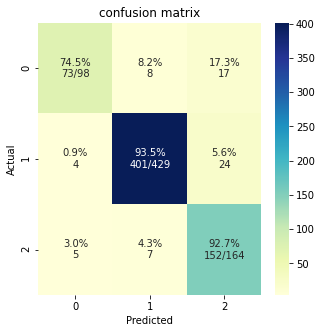

In [42]:
#making confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred = model.predict(eval_df1.text.to_list())[0]
y_true = eval_df1.labels

confusion_matrix(y_true, y_pred, labels=[0,1,2])

#confusion matrix is
#y-axis = predicted
#x-axis = actual
# 0 | 79  8   11
# 1 | 4   410 15
# 2 | 6   8   150
#    ____________   
#     0   1   2


import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels= np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

    
plot_cm(y_true, y_pred, 'confusion matrix')

In [43]:
from sklearn.metrics import classification_report
target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.89      0.74      0.81        98
     neutral       0.96      0.93      0.95       429
    positive       0.79      0.93      0.85       164

    accuracy                           0.91       691
   macro avg       0.88      0.87      0.87       691
weighted avg       0.91      0.91      0.91       691



# Testing the effect of pre-processing
This section tests the effect of pre-processing, namely lowercasing and stopwords.

In [ ]:
#all labels
eval_df.reset_index()['labels']

0      1
1      2
2      2
3      1
4      2
      ..
686    1
687    2
688    0
689    0
690    0
Name: labels, Length: 691, dtype: int64

In [ ]:
new_work.head()

,german via deepl,rating,lowercase,lower_stopword
0,"Laut Gran hat das Unternehmen keine Pläne, die...",1,"laut gran hat das unternehmen keine pläne, die...","laut gran unternehmen pläne , gesamte produkti..."
1,Mit der neuen Produktionsanlage würde das Unte...,2,mit der neuen produktionsanlage würde das unte...,neuen produktionsanlage unternehmen kapazität ...
2,Im letzten Quartal 2010 verdoppelte sich der U...,2,im letzten quartal 2010 verdoppelte sich der u...,letzten quartal 2010 verdoppelte umsatz compon...
3,Im dritten Quartal 2010 stiegen die Umsatzerlö...,2,im dritten quartal 2010 stiegen die umsatzerlö...,"dritten quartal 2010 stiegen umsatzerlöse 5,2 ..."
4,"Das Betriebsergebnis stieg von EUR 8,7 Mio. im...",2,"das betriebsergebnis stieg von eur 8,7 mio. im...","betriebsergebnis stieg eur 8,7 mio . vergleich..."


In [ ]:
#transform data to lists
normal_list = new_work['german via deepl'].to_list()
lower_list = new_work.lowercase.to_list()
lower_stopword_list = new_work.lower_stopword.to_list()

#predict on list level
result_normal = model.predict(normal_list)[0]
result_lowercase = model.predict(lower_list)[0]
result_lower_stopword = model.predict(lower_stopword_list)[0]

#add to df for print out
new_work['normal_prediction'] = pd.DataFrame(result_normal)
new_work['lowercase_prediction'] = result_lowercase
new_work['lower_stop_prediction'] = result_lower_stopword
new_work.head()

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3453 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3453 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3453 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

,german via deepl,rating,lowercase,lower_stopword,normal_prediction,lowercase_prediction,lower_stop_prediction
0,"Laut Gran hat das Unternehmen keine Pläne, die...",1,"laut gran hat das unternehmen keine pläne, die...","laut gran unternehmen pläne , gesamte produkti...",1,1,1
1,Mit der neuen Produktionsanlage würde das Unte...,2,mit der neuen produktionsanlage würde das unte...,neuen produktionsanlage unternehmen kapazität ...,2,2,2
2,Im letzten Quartal 2010 verdoppelte sich der U...,2,im letzten quartal 2010 verdoppelte sich der u...,letzten quartal 2010 verdoppelte umsatz compon...,2,2,2
3,Im dritten Quartal 2010 stiegen die Umsatzerlö...,2,im dritten quartal 2010 stiegen die umsatzerlö...,"dritten quartal 2010 stiegen umsatzerlöse 5,2 ...",2,2,2
4,"Das Betriebsergebnis stieg von EUR 8,7 Mio. im...",2,"das betriebsergebnis stieg von eur 8,7 mio. im...","betriebsergebnis stieg eur 8,7 mio . vergleich...",2,2,2


In [ ]:
#if ratings of original data and predicted data agree 1, otherwise 0
new_work['normal_correct'] = np.where(new_work['rating'] == new_work['normal_prediction'], '1', '0')
new_work['lowercase_correct'] = np.where(new_work['rating'] == new_work['lowercase_prediction'], '1', '0')
new_work['lower_stopword_correct'] = np.where(new_work['rating'] == new_work['lower_stop_prediction'], '1', '0')

In [ ]:
#count values and by doing that determine how many ratings were correct, thus seeing how strongly pre-processing affected prediction performance
new_work['normal_correct'].value_counts()
print('Normal accuracy is', new_work['normal_correct'].value_counts()[0]/3451)

new_work['lowercase_correct'].value_counts()
print('Lowercase accuracy is', new_work['lowercase_correct'].value_counts()[0]/3451)

new_work['lower_stopword_correct'].value_counts()
print('Lower_stopword accuracy is', new_work['lower_stopword_correct'].value_counts()[0]/3451)

Normal accuracy is 0.9831932773109243
Lowercase accuracy is 0.9356708200521588
Lower_stopword accuracy is 0.8058533758330919


In [ ]:
#get data from original text out of dataframe
eval_list = eval_df['text'].to_list()

#use the model on the text
result = model.predict(eval_list)[0]

#take the predicted results and put it into a dataframe
new_df['predicted_label'] = pd.DataFrame(result)
new_df['correct_label'] = eval_df.reset_index()['labels']
new_df.rename(columns ={0:"predicted_label", 1:'correct_label'})


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

,predicted_label,correct_label,predicted_label
0,1,1,1
1,2,2,2
2,2,2,2
3,1,1,1
4,2,2,2
...,...,...,...
686,1,1,1
687,2,2,2
688,0,0,0
689,0,0,0


In [ ]:
model.predict(['Umsatzsteigerung in den ersten 9 Monaten 2018 um 11%.'])[0]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[2]

In [ ]:
model.predict(['UMSATZSTEIGERUNG IN DEN ERSTEN 9 MONATEN 2018 UM 11%'])[0]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[1]

In [ ]:
model.predict(['umsatzsteigerung in den ersten 9 monaten 2018 um 11%.'])[0]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[2]

In [ ]:
model.predict(['umsatzsteigerung ersten monaten.'])[0]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[2]

# Stock Data
This section downloads stock data for the 15 companies using yfinance

In [ ]:
import nltk
sentences = nltk.sent_tokenize(text,language='german')


In [ ]:
#load all earnings reports and news articles
excel_test = pd.read_excel('/content/drive/My Drive/colab_notebooks/all_news_articles_and_earnings_reports.xlsx')
excel_test

,company_ticker,market_cap_mio_chf,mid_or_small,document_name,document_type,source,publication_date,original_text
0,CALN,297,small_cap,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,2015: Solides Ergebnis trotz schwachem Euro. D...
1,TECN,5150,mid_cap,160315_PR_Tecan_with_high_growth_in_sales_and_...,annual_earnings_report,company,2016-03-15,Die Tecan Group (SIX Swiss Exchange: TECN) hat...
2,SUN,3942,small_cap,160421_Order_Intake_in_All_Markets_Improved_Ex...,quarterly_earnings_report,company,2016-04-21,"Die Bestellungen in den Märkten Energie, Wasse..."
3,TECN,5150,mid_cap,160816_PR_Tecan_again_posts_double-digit_sales...,quarterly_earnings_report,company,2016-08-16,Tecan im ersten Halbjahr 2016 erneut mit zweis...
4,SUN,3942,small_cap,161020_All_Markets_Were_Stable_or_Improved_Exc...,quarterly_earnings_report,company,2016-10-20,In den ersten neun Monaten des Jahres verringe...
...,...,...,...,...,...,...,...,...
665,ZEHN,972,small_cap,zehn_29.07.2016.txt,quarterly_earnings_report,company,2016-07-29,Umsatzsteigerung und Ergebnisverbesserung. Die...
666,ZEHN,972,small_cap,ZEHN_29.07.2020 (2).txt,news,cash.ch,2020-07-29,Zehnder übertrifft Erwartungen deutlich. Die a...
667,ZEHN,972,small_cap,zehn_29.07.2020.txt1,quarterly_earnings_report,company,2020-07-29,Umsatzrückgang – EBIT leicht gesteigert. Der U...
668,ZEHN,972,small_cap,ZEHN_29.07.2020.txt,news,cash.ch,2020-07-29,Zehnder-Aktien legen kräftig zu - Halbjahresza...


In [ ]:
#apply tokenizer
def apply_tokenize(x):
    sentence = nltk.sent_tokenize(x,language='german')
    return sentence

In [ ]:
#reform dataframe so that text gets tokenized and the ticker, document name and publication date are attached to it
c = pd.DataFrame([apply_tokenize(x) for x in excel_test['original_text']], 
                 index=[excel_test.company_ticker, excel_test.market_cap_mio_chf, excel_test.document_name, excel_test.document_type, excel_test.source, excel_test.publication_date]).stack()
c = c.reset_index(drop=False)
c = c.drop('level_6', axis=1)
c.columns=['company_ticker', 'market_cap_mio_chf', 'document_name', 'document_type','source', 'publication_date', 'original_text']
c.original_text = c.original_text.str.replace('\n', ' ')
c

,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text
0,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,2015: Solides Ergebnis trotz schwachem Euro.
1,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Die CALIDA Gruppe hat sich im Geschäftsjahr 20...
2,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Die Marktbedingungen waren im Lichte der Währu...
3,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Aber das Geschäftsmodell mit einem starken Meh...
4,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Währungsbedingt waren der Nettoumsatz im Jahre...
...,...,...,...,...,...,...,...
20552,ZEHN,972,ZEHN_31.05.2017.txt,news,cash.ch,2017-05-31,Zehnder unterbricht Produktion am Standort Man...
20553,ZEHN,972,ZEHN_31.05.2017.txt,news,cash.ch,2017-05-31,Die in den Bereichen Heizung und Lüftung tätig...
20554,ZEHN,972,ZEHN_31.05.2017.txt,news,cash.ch,2017-05-31,Grund für den Unterbruch seien kürzlich verzei...
20555,ZEHN,972,ZEHN_31.05.2017.txt,news,cash.ch,2017-05-31,Man werde zeitnah über die eingeleiteten Massn...


In [ ]:
# apply flesch and apply wiener
c['flesch_score'] = [apply_flesch(x) for x in c['original_text']]
c['wiener_score'] = [apply_wiener(x) for x in c['original_text']]
c.head()

,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text,flesch_score,wiener_score
0,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,2015: Solides Ergebnis trotz schwachem Euro.,57.00,11.428200
1,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Die CALIDA Gruppe hat sich im Geschäftsjahr 20...,59.70,12.391667
2,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Die Marktbedingungen waren im Lichte der Währu...,30.60,10.682022
3,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Aber das Geschäftsmodell mit einem starken Meh...,44.85,10.536133
4,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Währungsbedingt waren der Nettoumsatz im Jahre...,29.45,12.090825


In [ ]:
#get data from original text out of dataframe
e = c['original_text'].to_list()

#use the model on the text
result = model.predict(e)

#take the predicted results and put it into a dataframe
df_result = pd.DataFrame(result).transpose()
df_result.rename(columns ={0:"score", 1:'details'})

#attach it to the original dataframe
c['predicted_sentiment_score'] = df_result.iloc[:,0:1]
c.head(14)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20557 [00:00<?, ?it/s]

  0%|          | 0/2570 [00:00<?, ?it/s]

,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text,flesch_score,wiener_score,predicted_sentiment_score
0,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,2015: Solides Ergebnis trotz schwachem Euro.,57.00,11.428200,2
1,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Die CALIDA Gruppe hat sich im Geschäftsjahr 20...,59.70,12.391667,2
2,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Die Marktbedingungen waren im Lichte der Währu...,30.60,10.682022,0
3,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Aber das Geschäftsmodell mit einem starken Meh...,44.85,10.536133,2
4,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Währungsbedingt waren der Nettoumsatz im Jahre...,29.45,12.090825,0
5,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Der operative Cashflow und die Nettoliquidität...,18.60,14.478581,2
6,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Das Geschäftsjahr 2016 lief gut an.,97.95,2.789867,2
7,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,„Im abgelaufenen Geschäftsjahr lag der strateg...,13.90,15.757229,1
8,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,"Es ging nicht zuletzt darum, die Ertragskraft ...",56.70,10.382378,2
9,CALN,297,160307 Medienmitteiliung_DE_def 2.pdf,quarterly_earnings_report,company,2016-03-07,Wir haben trotz des schwierigen Umfeldes weite...,50.00,14.215523,2


In [ ]:
#export to csv and download
from google.colab import files
c.to_csv('sentiment_results.csv') 
files.download('sentiment_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
c.head(117)

,company_ticker,market_cap_mio_chf,document_name,document_type,source,publication_date,original_text,flesch_score,wiener_score,predicted_sentiment_score
0,STMN,22432,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,"Ausblick Straumann: Jahresgewinn von 74,2 Mill...",31.60,16.628850,1
1,STMN,22432,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Der Dentalimplantat-Hersteller Straumann gibt ...,49.65,11.101667,1
2,STMN,22432,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,FOKUS: Die Geschäfte des Basler Unternehmens w...,41.15,11.692075,0
3,STMN,22432,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Statt der üblichen zweistelligen Zuwachsraten ...,35.15,13.369309,0
4,STMN,22432,STMN_15.02.2021.txt,news,cash.ch,2021-02-15,Seither macht sich allerdings wieder eine star...,48.15,14.636467,2
...,...,...,...,...,...,...,...,...,...,...
112,STMN,22432,Straumann-Q1-25_04_2018-Medienmitteilung.txt,quarterly_earnings_report,company,2018-04-25,Straumann: Starkes Wachstum setzt sich fort – ...,66.55,9.313657,2
113,STMN,22432,Straumann-Q1-25_04_2018-Medienmitteilung.txt,quarterly_earnings_report,company,2018-04-25,Umsatz der Gruppe in Schweizer Franken steigt ...,90.95,4.274754,2
114,STMN,22432,Straumann-Q1-25_04_2018-Medienmitteilung.txt,quarterly_earnings_report,company,2018-04-25,Starkes organisches Wachstum in allen Regionen...,19.90,14.598850,2
115,STMN,22432,Straumann-Q1-25_04_2018-Medienmitteilung.txt,quarterly_earnings_report,company,2018-04-25,Premium- und Non-Premium-Aktivitäten stärker z...,-1.66,21.864733,2


In [ ]:
#import yfinance
!pip install yfinance
import yfinance as yf


     |████████████████████████████████| 6.3MB 29.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=f71768f3e23bf28918d07bd43028df9c48b248791e48a064619e05248082bfbd
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
#define what to download (15 companies with 1d interval)
stock_data = yf.download(tickers = 'STMN.SW SOON.SW VACN.SW TECN.SW OERL.SW BUCN.SW EMMN.SW BEAN.SW SUN.SW BELL.SW BCHN.SW ARBN.SW ZEHN.SW FTON.SW CALN.SW',                      
                      start = '2016-01-01',
                      end = '2021-06-10',
                      interval = '1d',
                      group_by = 'column',
                      prepost = False, #no pre and post market information 
                      progress=False)

In [ ]:
#test = stock_data.drop(columns = ['Close', 'Open', 'High', 'Low']) #only keeping adj close and volume
stock_data.to_csv('stockdata.csv') 
files.download('stockdata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
#End of code